In [1]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from numpy import random
import os
from os.path import isfile, join
import pandas as pd
from math import ceil
%matplotlib inline

Using TensorFlow backend.


In [2]:
master_image_size = 256, 256
master_color_channels = 1
random.seed(0)
base_image_dir = 'grayscale_molecules'

In [8]:
def get_new_model():
    """
    Creates a new CNN model. It also prints a summary of the
    model.
    
    It uses the external variables master_image_size and
    master_color_channels to setup the input layer.
    
    Returns
    -------
    keras.models.Sequential
        The model ready to be trained
    """
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(master_image_size[0], master_image_size[1], master_color_channels)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=0.5e-4), metrics=['acc'])
    
    model.summary()
    
    return model

In [5]:
def train_validation_test(base_path, train_fraction=0.8, shuffle_seed=0):
    """
    Reads images in a directory and splits them up according to class
    
    Assumes a binary classification, with EQUAL COUNTS in each
    class.
    
    This automatically assigns classes to the images. It assumes
    the name of each class is the first token of the filename as
    delimited by "_".
    
    The dataframes returned are to be used by Keras. They have the
    columns "filename" and "class" to point to the images and the
    classes, repectively.
    
    Parameters
    ----------
    base_path : str
        The relative path to the images.
        
    train_fraction : int
        The fraction of the images set to use for training images.
        Whatever isn't used for training is split between test and
        training datasets.
        
    shuffle_seed : int
        The integer to seed the random number generator which shuffles
        the dataframe.
        
    Returns
    -------
    pd.DataFrame, pd.DataFrame, pd.DataFrame
        The train, validation and test sets, respectively.
    """
    random.seed(shuffle_seed)
    
    all_images_list = []
    
    for filename in os.listdir(base_path):
        if isfile(join(base_path, filename)):
            image_class = filename.split('.')[0]
            all_images_list.append({'class': image_class, 'filename': filename})
    
    all_images = pd.DataFrame(all_images_list)
    all_images = all_images.sample(frac=1).reset_index(drop=True)
    all_classes = all_images['class'].unique()
    
    first_class_name = all_classes[0]
    second_class_name = all_classes[1]
    
    first_class = all_images.copy().where(all_images['class'] == first_class_name).dropna()
    second_class = all_images.copy().where(all_images['class'] == second_class_name).dropna()

    train_row_count = int(len(first_class) * train_fraction)
    test_val_count = len(first_class) - train_row_count
    
    first_class_train = first_class.iloc[2 * test_val_count:]
    first_class_val = first_class.iloc[test_val_count:2 * test_val_count]
    first_class_test = first_class.iloc[0:test_val_count]
    
    second_class_train = second_class.iloc[2 * test_val_count:]
    second_class_val = second_class.iloc[test_val_count:2 * test_val_count]
    second_class_test = second_class.iloc[0:test_val_count]
    
    train = first_class_train.append(second_class_train).reset_index().drop('index', axis=1)
    val = first_class_val.append(second_class_val).reset_index().drop('index', axis=1)
    test = first_class_test.append(second_class_test).reset_index().drop('index', axis=1)
    
    return train, val, test

In [10]:
def train_validation_test_generators(src_dir, train_fraction=0.8, shuffle_seed=0):
    """
    Creates generators for train, validation and test datasets. These
    can then be used by Keras to train a model.
    
    Dataframe shuffling is prevented at this step because the dataframe
    is assumed to have been shuffled beforehand with an RNG with a known
    seed.
    
    The dataframe is created for you from the images in src_dir. See the
    train_validation_test function for more information.
    
    Parameters
    ----------
    src_dir : str
        The relative path to the train, validation and test images
    
    train_fraction : float
        The fraction of the images to be used for the training dataset.
        See train_validation_test for more.
        
    shuffle_seed : int
        The seed for the RNG used for dataframe shuffling.
    """
    train, validation, test = train_validation_test(src_dir, train_fraction, shuffle_seed)

    train_datagen = image.ImageDataGenerator(rescale=1.0/255)
    test_datagen = image.ImageDataGenerator(rescale=1.0/255)
    validation_datagen = image.ImageDataGenerator(rescale=1.0/255)

    train_generator = train_datagen.flow_from_dataframe(dataframe=train,
                                                        directory=src_dir,
                                                        target_size=master_image_size,
                                                        batch_size=20,
                                                        shuffle=False,
                                                        color_mode='grayscale',
                                                        class_mode='binary')

    validation_generator = train_datagen.flow_from_dataframe(dataframe=validation,
                                                      directory=src_dir,
                                                      target_size=master_image_size,
                                                      batch_size=20,
                                                      shuffle=False,
                                                      color_mode='grayscale',
                                                      class_mode='binary')

    test_generator = train_datagen.flow_from_dataframe(dataframe=test,
                                                       directory=src_dir,
                                                       target_size=master_image_size,
                                                       batch_size=20,
                                                       shuffle=False,
                                                       color_mode='grayscale',
                                                       class_mode='binary')
    
    return train_generator, validation_generator, test_generator

In [11]:
def train_model_and_get_history(base_image_dir, shuffle_seed=0):
    """
    Trains a model and returns the RNG seed and history
    
    Parameters
    ----------
    base_image_dir : str
        The relative path to the images.
        
    shuffle_seed : int
        The seed for the RNG that shuffles the train, validation
        and test datasets.
        
    Returns
    -------
    int, dict
        The RNG seed and history dictionary of the training run.
    """
    train_generator, validation_generator, test_generator = train_validation_test_generators(base_image_dir, shuffle_seed)
    model = get_new_model()
    train_history = model.fit_generator(train_generator,
                                        steps_per_epoch=100,
                                        epochs=10,
                                        validation_data=validation_generator,
                                        validation_steps=50,
                                        verbose=1)
    return train_history

In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       147584    
__________

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

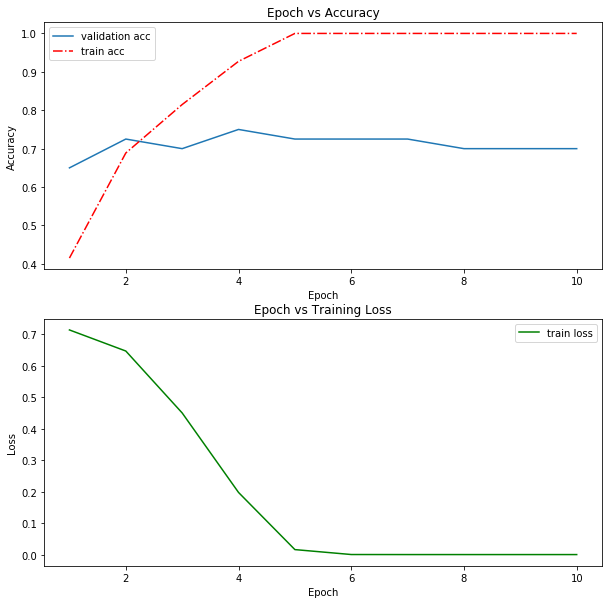

In [9]:
epochs = range(1, len(acc) + 1)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Epoch vs Accuracy')
axs[0].plot(epochs, val_acc, label='validation acc')
axs[0].plot(epochs, acc, 'r', ls='-.', label='train acc')
axs[0].legend()

axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Epoch vs Training Loss')
axs[1].plot(epochs, loss, 'g', label='train loss')
axs[1].legend()

In [10]:
print(f'Validation accuracy max at epoch {np.array(val_acc).argmax() + 1} is {max(val_acc)}')

Validation accuracy max at epoch 4 is 0.75


In [11]:
train_generator, validation_generator, test_generator = train_validation_test_generators(base_image_dir)

model = get_new_model()

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=4,
                              validation_data=validation_generator,
                              validation_steps=50)

Found 118 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.
Epoch 1/4
100/100 [==============================] - 10s 105ms/step - loss: 0.7133 - acc: 0.4225 - val_loss: 0.6892 - val_acc: 0.6500
Epoch 2/4
100/100 [==============================] - 10s 100ms/step - loss: 0.6485 - acc: 0.6899 - val_loss: 0.6025 - val_acc: 0.7250
Epoch 3/4
100/100 [==============================] - 10s 100ms/step - loss: 0.4540 - acc: 0.8140 - val_loss: 0.5832 - val_acc: 0.6750
Epoch 4/4
100/100 [==============================] - 10s 101ms/step - loss: 0.2015 - acc: 0.9255 - val_loss: 0.6402 - val_acc: 0.7500


In [12]:
def name_of_class_from_prediction_value(value):
    if value < 0.25:
        return 'ring'
    elif value > 0.75:
        return 'NO ring'
    else:
        return 'WTF?'

In [13]:
def read_images_from_df_and_classify(test_df, dirname, image_size, classifier):
    singles = []
    for filename in test_df['filename']:
        single = image.load_img(os.path.join(dirname, filename), target_size=image_size, color_mode='grayscale')
        single = image.img_to_array(single)
        single /= 255.0
        singles.append(single)
    batch = np.stack(singles, axis=0)
    predicted_classes = classifier.predict(batch)
    return singles, predicted_classes.flatten()

In [14]:
def classify_images_from_df_and_display(test_df, dirname, image_size, classifer):
    images, predicted_classes = read_images_from_df_and_classify(test_df, dirname, image_size, classifer)
    ncols = 4
    nrows = int(ceil(len(images) / ncols))
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 40))
    for image, predicted_class, ax in zip(images, predicted_classes, axs.reshape(-1)):
        title = name_of_class_from_prediction_value(predicted_class)
        ax.imshow(image.reshape(image_size), cmap='gray')
        ax.set_title(title)

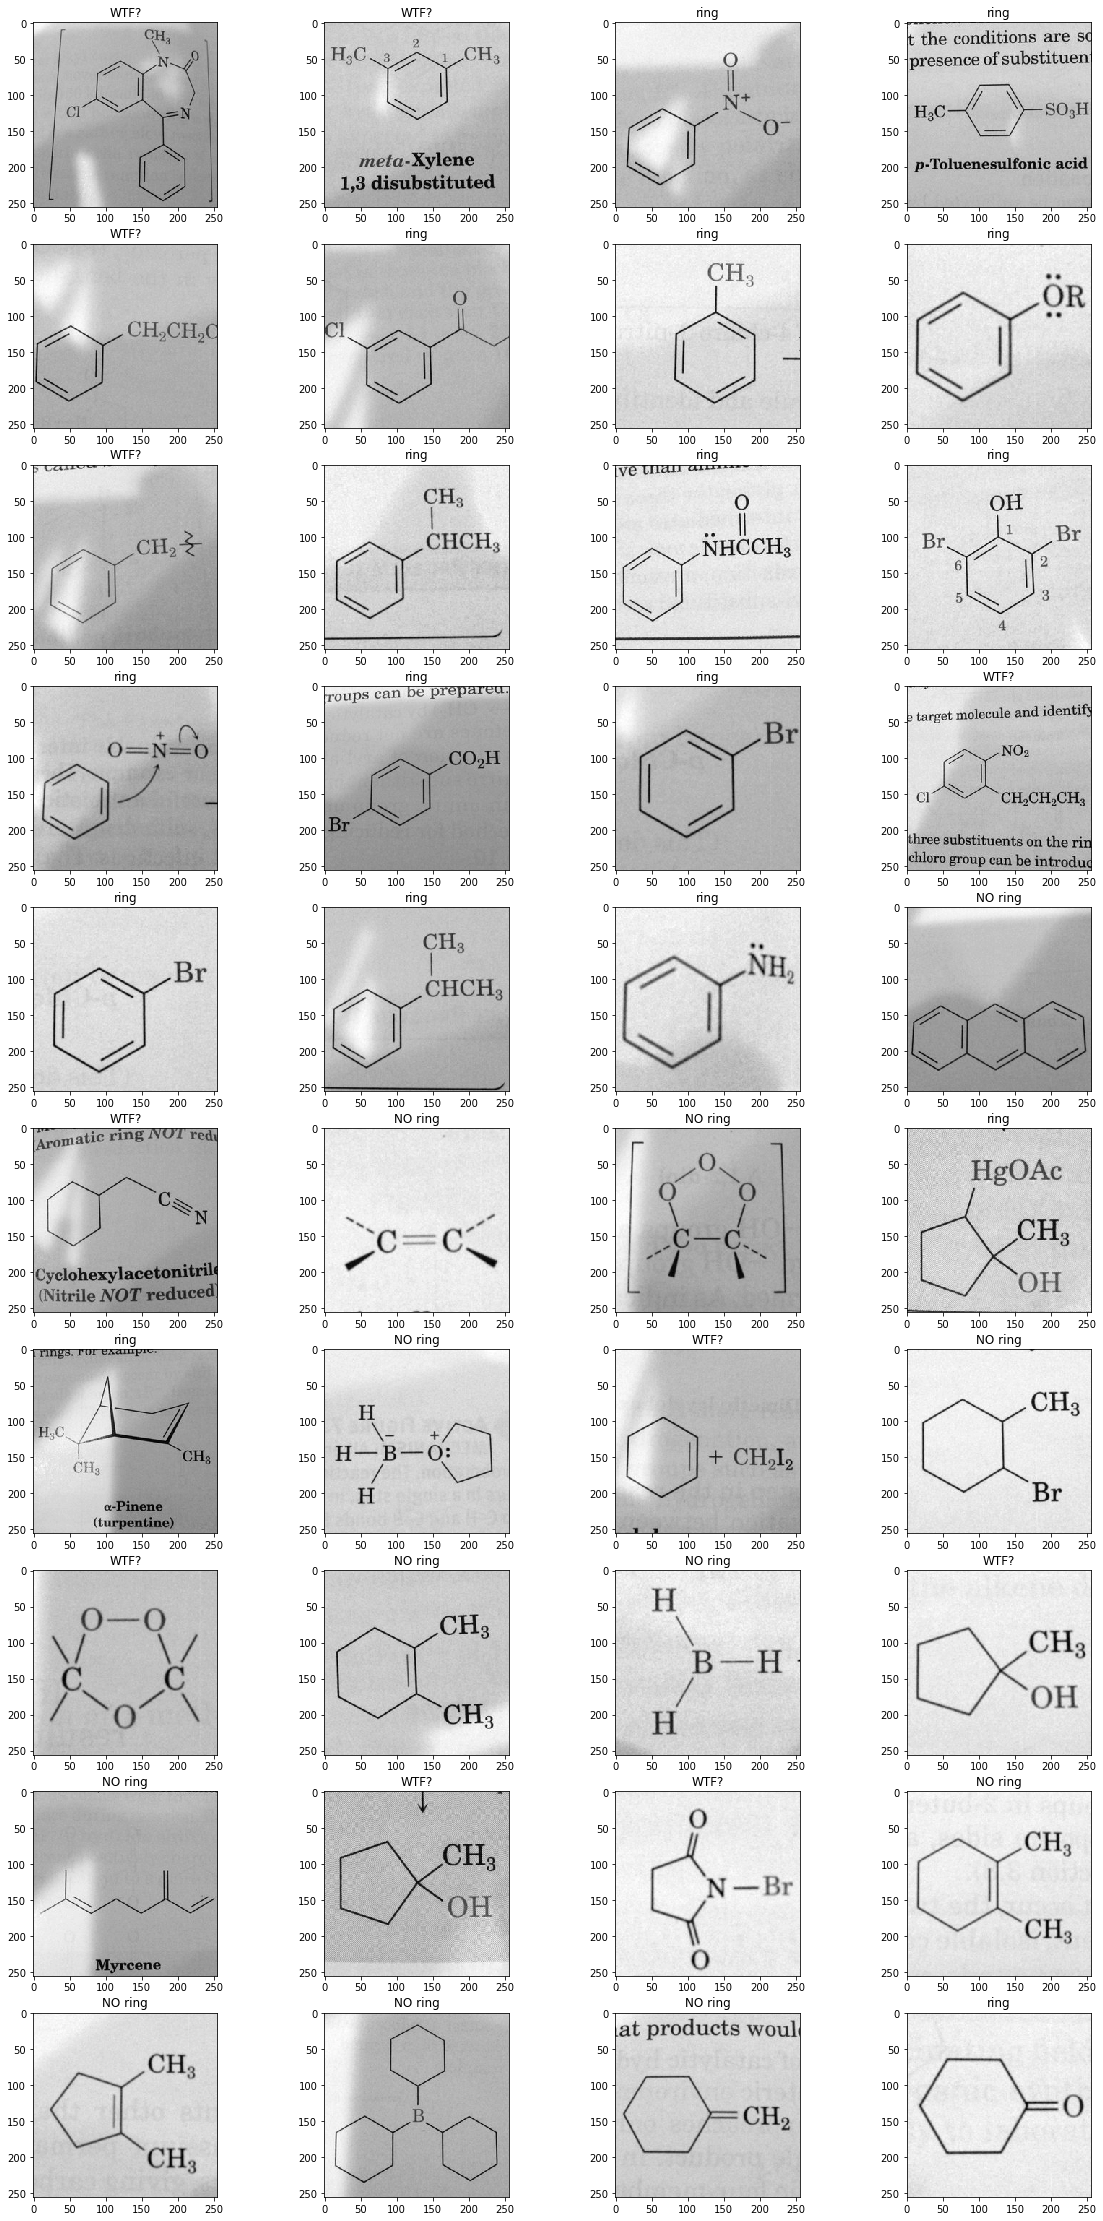

In [15]:
_, _, test = train_validation_test(base_image_dir)
classify_images_from_df_and_display(test, base_image_dir, master_image_size, model)